In [1]:
import sys
sys.path.insert(0, '../../_libs/')
import NEMO_tools as Nts
import Atmos_tools as Ats

In [2]:
import glob
import datetime
import scipy.io
import numpy as np
import seaborn as sb
import netCDF4 as nc
import matplotlib.pyplot as plt
from scipy.signal import detrend
from scipy.stats.stats import pearsonr
from NEMO_tools import reporj_NEMOgrid
from mpl_toolkits.basemap import Basemap, cm
% matplotlib inline

:0: FutureWarning: IPython widgets are experimental and may change in the future.


In [10]:
sb.set_style('white')
RB=[0.25, 0.41, 0.88]    # Royal blue
AM=[0.90, 0.17, 0.31]    # Amathran

In [3]:
from dateutil.relativedelta import relativedelta
base = datetime.datetime(2002, 1, 1)
date_list = [base + relativedelta(months=x) for x in range(144)]

In [4]:
coordinate_name=glob.glob('/ocean/yingkai/GEOTRACES/NEMO-CODE/NEMOGCM/CONFIG/ANHA4_OFF/EXP00/mesh_zgr.nc')
coordinate_obj=nc.Dataset(coordinate_name[0])
nav_lon=coordinate_obj.variables['nav_lon'][:]
nav_lat=coordinate_obj.variables['nav_lat'][:]
e1t = coordinate_obj.variables['e1t'][:]
e2t = coordinate_obj.variables['e2t'][:]
e3t = coordinate_obj.variables['e3t_0'][:]

In [5]:
obj_h = nc.Dataset('/ocean/yingkai/GEOTRACES/FORCING/ANHA4/sossheig_monmean.nc')


ssh = obj_h.variables['sossheig'][:]
ssh[ssh>100] = np.nan

In [6]:
ssh[np.isnan(ssh)] = 0
ssh_a = Ats.seasonal_decomp3d(ssh)
ssh_ad = detrend(ssh_a, 0)

In [7]:
ssh_eof = np.transpose(ssh_ad[:, 350:, :], [1, 2, 0])

In [8]:
EOFs, PC, expvar = Ats.EOF(ssh_eof, nmode=10, ndim=3, reverse=1)

../../_libs/Atmos_tools.py:308: ComplexWarning: Casting complex values to real discards the imaginary part
  eof[i, :] = np.squeeze(E[:, i]).T
../../_libs/Atmos_tools.py:309: ComplexWarning: Casting complex values to real discards the imaginary part
  PC[i, :]  = np.squeeze(Z[i, :])


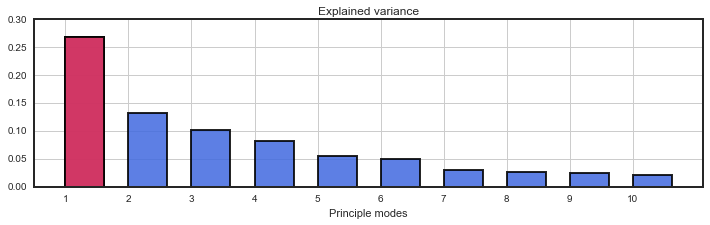

In [11]:
fig=plt.figure(figsize=(12, 3))
ax=plt.gca(); ax.grid(); ax.set_xlim(0.5, 11.118)
ax.bar(np.arange(1, 11), expvar, width=0.618, lw=2, alpha=0.85, color=RB)
ax.bar(1, expvar[0], width=0.618, lw=2, alpha=0.85, color=AM)
ax.set_xticks(np.arange(1, 11))
[i.set_linewidth(2) for i in ax.spines.itervalues()]
ax.set_xlabel('Principle modes')
ax.set_title('Explained variance', fontsize=12)

In [12]:
def draw_smode(lon, lat, EOFs, clevs, num, ax):
    proj=Basemap(projection='npstere', resolution='l', boundinglat=60, lon_0=0, round=True, ax=ax)
    #proj.drawparallels(np.arange(59, 100, 10), labels=[1, 1, 1, 1], fontsize=10, latmax=90, linewidth=0)
    proj.drawmeridians(np.arange(0, 360, 120), labels=[1, 1, 1, 1], fontsize=10, latmax=90, linewidth=0)
    proj.fillcontinents(color=[0.8, 0.8, 0.8], lake_color=None)
    proj.drawcoastlines(linewidth=0.5, color='k')
    x, y = proj(lon, lat)
    CS = proj.contourf(x, y, EOFs[:, :, num], clevs, cmap=plt.cm.RdBu_r, extend='both')
    #proj.contour(x, y, EOFs[:, :, num], clevs, colors='gray', linewidths=1.5)
    return CS

In [22]:
clevs = np.array([-5.5, -4.5, -3.5, -2.5, -1.5, -0.5, 0.5, 1.5, 2.5, 3.5, 4.5, 5.5])/110.0

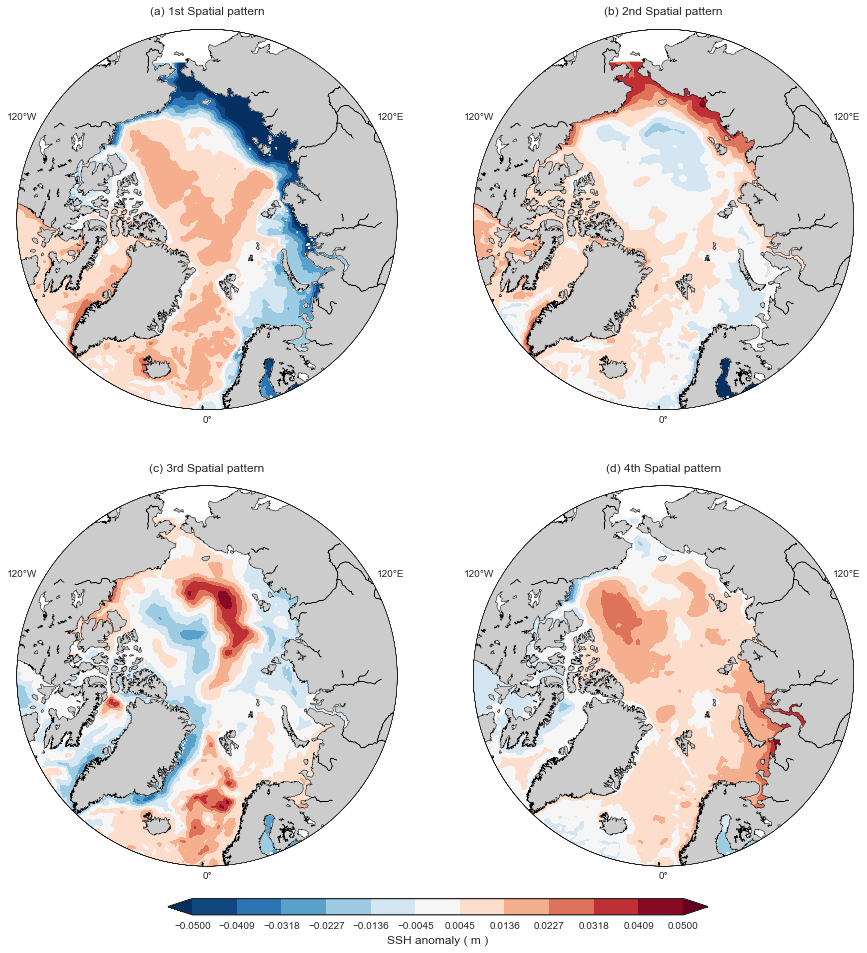

In [23]:
fig = plt.figure(figsize=(15, 15))
ax1 = plt.subplot2grid((2, 2), (0, 0), colspan=1, rowspan=1)
ax2 = plt.subplot2grid((2, 2), (0, 1), colspan=1, rowspan=1)
ax3 = plt.subplot2grid((2, 2), (1, 0), colspan=1, rowspan=1)
ax4 = plt.subplot2grid((2, 2), (1, 1), colspan=1, rowspan=1)
#
CS = draw_smode(nav_lon[350:, :], nav_lat[350:, :], EOFs, clevs, 0, ax1)
ax1.set_title('(a) 1st Spatial pattern', y=1.025)
draw_smode(nav_lon[350:, :], nav_lat[350:, :], EOFs, clevs, 1, ax2)
ax2.set_title('(b) 2nd Spatial pattern', y=1.025)
draw_smode(nav_lon[350:, :], nav_lat[350:, :], EOFs, clevs, 2, ax3)
ax3.set_title('(c) 3rd Spatial pattern', y=1.025)
draw_smode(nav_lon[350:, :], nav_lat[350:, :], EOFs, clevs, 3, ax4)
ax4.set_title('(d) 4th Spatial pattern', y=1.025)
#colorbar
cax  = fig.add_axes([0.265, 0.08, 0.5, 0.015])
CBar = fig.colorbar(CS, cax=cax, orientation='horizontal')
CBar.set_label('SSH anomaly ( m )', fontsize=12)
CBar.ax.tick_params(axis='x', length=0, direction='in')
CBar.set_ticks(clevs)

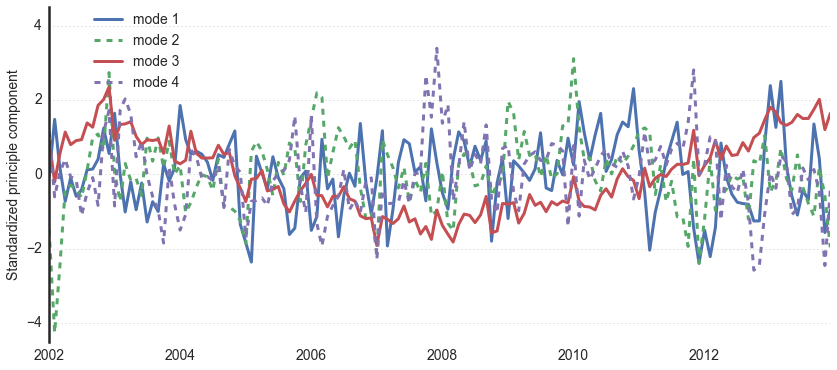

In [24]:
fig = plt.figure(figsize=(14, 6))
ax = fig.gca()
ax.grid(linestyle=':')
ax.yaxis.grid(False)
ax.spines["top"].set_visible(False)
ax.spines["bottom"].set_visible(False) 
ax.spines["right"].set_visible(False)
ax.set_xlim([date_list[0], date_list[143]])
ax.set_ylim([-4.5, 4.5])
ax.set_ylabel('Standardized principle component', fontsize=14)
ax.xaxis.set_tick_params(labelsize=14)
ax.yaxis.set_tick_params(labelsize=14)
[i.set_linewidth(2.5) for i in ax.spines.itervalues()] 
ax.tick_params(axis="both", which="both", bottom="off", top="off",    
            labelbottom="on", left="off", right="off", labelleft="on")

ax = fig.gca(); ax.grid()
ax.plot(date_list, PC[0, :], '-',  lw=3, label='mode 1')
ax.plot(date_list, PC[1, :], '--', lw=3, label='mode 2')
ax.plot(date_list, PC[2, :], '-',  lw=3, label='mode 3')
ax.plot(date_list, PC[3, :], '--', lw=3, label='mode 4')

LG = ax.legend(numpoints=1, bbox_to_anchor=(0.05, 1.0), loc=2, borderaxespad=0., prop={'size':14}); LG.draw_frame(False)